In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_salaries = pd.read_csv("./datasets/salaries.csv")

In [3]:
df_salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [4]:
# Create copies of the dataframe for EDA and bucketing
df_salaries_eda = df_salaries.copy()
df_salaries_bucketing = df_salaries.copy()

## Exploratory Data Analysis


In [5]:
df_salaries_eda.head(10)

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20
5,105,10,12102.18
6,80,3,5723.35
7,85,2,6424.92
8,66,5,3916.18
9,73,5,4751.79


In [6]:
# Count the number of missing values in the dataframe
df_salaries_eda.isna().sum()

tempo_na_empresa    0
nivel_na_empresa    0
salario_em_reais    0
dtype: int64

In [7]:
df_salaries_eda.describe()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
count,1000.000000,1000.000000,1000.000000
mean,59.712000,5.467000,5093.726110
std,34.027679,2.889509,4536.168857
min,1.000000,1.000000,538.560000
25%,30.750000,3.000000,1537.477500
50%,60.000000,6.000000,3237.920000
75%,89.000000,8.000000,7436.680000
max,120.000000,10.000000,18923.230000


The salary column (target) has a mean of **R$ 5093.72** and a median of **R$ 3237.92**. The distribution of the salary is right-skewed with a long tail. This indicates that there are a few people who earn a very high salary. A **linear regression model** may not be the best model for this data because of the skewness.


Text(0.5, 1.0, 'Boxplot of Years at Company')

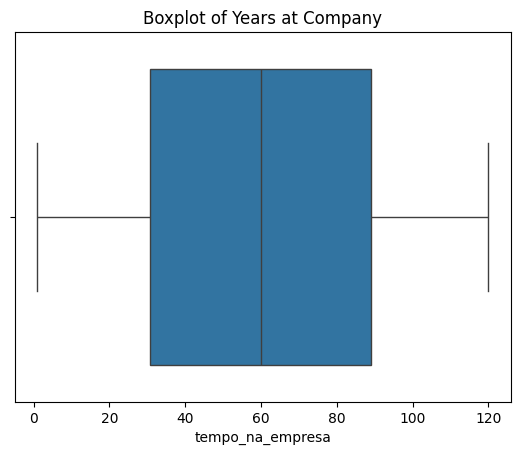

In [8]:
sns.boxplot(x=df_salaries_eda["tempo_na_empresa"])
plt.title("Boxplot of Years at Company")

Text(0.5, 1.0, 'Boxplot of Job Level')

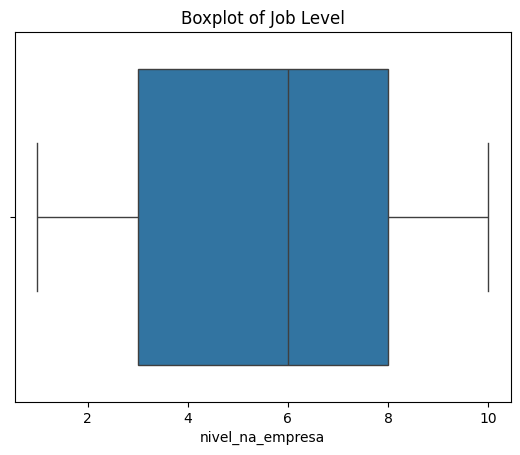

In [9]:
sns.boxplot(x=df_salaries_eda["nivel_na_empresa"])
plt.title("Boxplot of Job Level")

Text(0.5, 1.0, 'Boxplot of Salary in BRL')

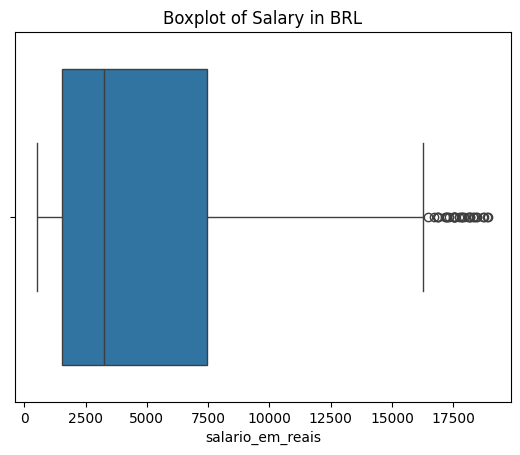

In [10]:
sns.boxplot(x=df_salaries_eda["salario_em_reais"])
plt.title("Boxplot of Salary in BRL")

There are many outliers in the salary column. The maximum salary is **R$ 18,923.23** and the minimum salary is **R$ 538,56**. The 75th percentile is **R$ 7,436.68** and the 25th percentile is **R$ 1,537.47**. The outliers are the salaries that are above **R$ 15,000.00**, but they should not be removed because they are valid data points. The outliers are the people who earn a very high salary, like managers and directors.


Text(0.5, 1.0, 'Scatterplot of Years at Company vs Salary')

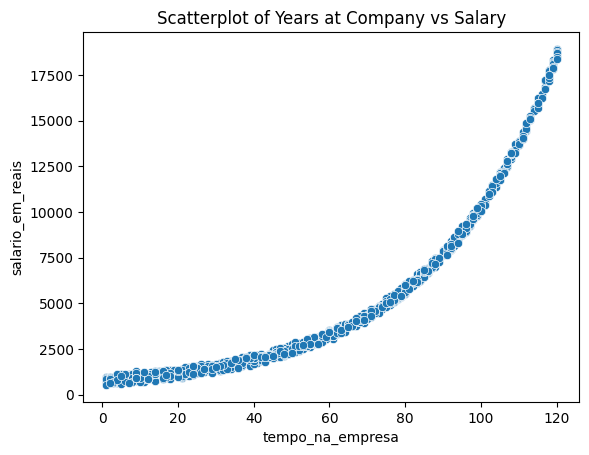

In [11]:
sns.scatterplot(
    x=df_salaries_eda["tempo_na_empresa"], y=df_salaries_eda["salario_em_reais"]
)
plt.title("Scatterplot of Years at Company vs Salary")

Text(0.5, 1.0, 'Scatterplot of Job Level vs Salary')

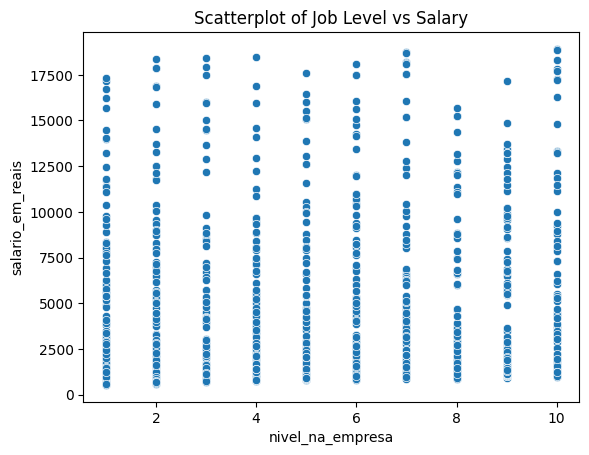

In [12]:
sns.scatterplot(
    x=df_salaries_eda["nivel_na_empresa"], y=df_salaries_eda["salario_em_reais"]
)
plt.title("Scatterplot of Job Level vs Salary")

Text(0.5, 1.0, 'Scatterplot of Job Level vs Years at Company')

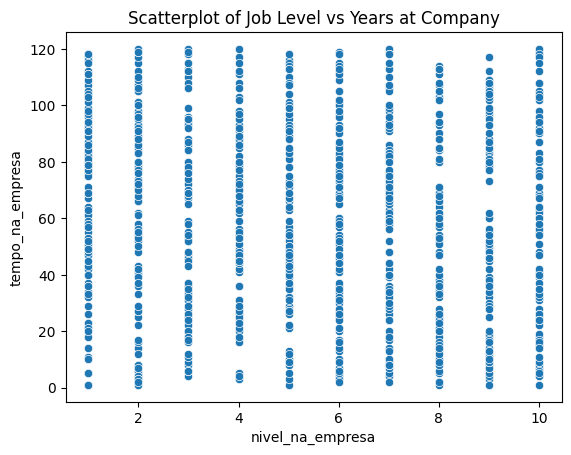

In [13]:
sns.scatterplot(
    x=df_salaries_eda["nivel_na_empresa"], y=df_salaries_eda["tempo_na_empresa"]
)
plt.title("Scatterplot of Job Level vs Years at Company")

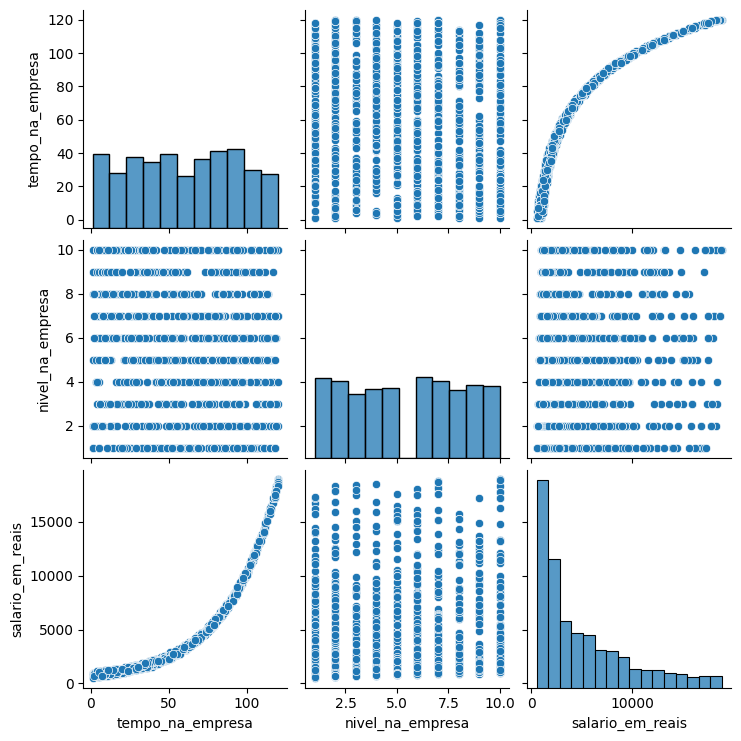

In [14]:
sns.pairplot(df_salaries_eda)

Text(0.5, 1.0, 'Correlation Matrix (Pearson)')

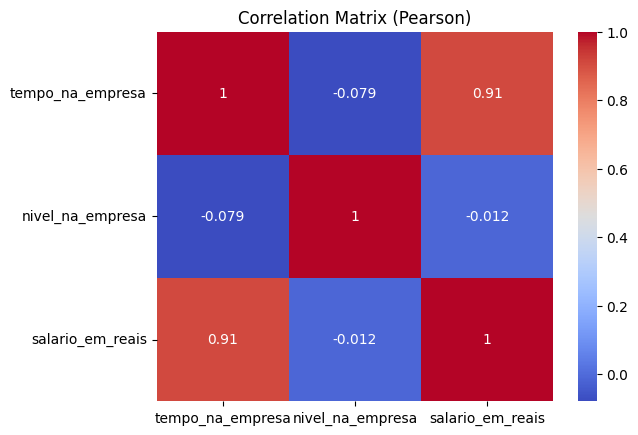

In [15]:
sns.heatmap(df_salaries_eda.corr("pearson"), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Pearson)")

Text(0.5, 1.0, 'Correlation Matrix (Spearman)')

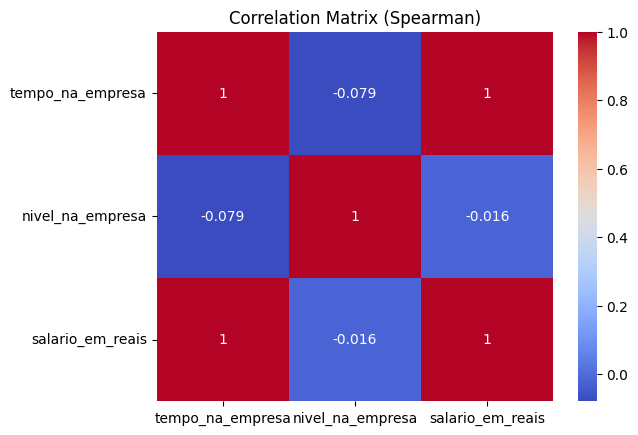

In [16]:
# Spearman is preferred because it's more suited for non-linear relationships
sns.heatmap(df_salaries_eda.corr("spearman"), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Spearman)")

Text(0.5, 1.0, 'Correlation of Salary in BRL with Other Variables')

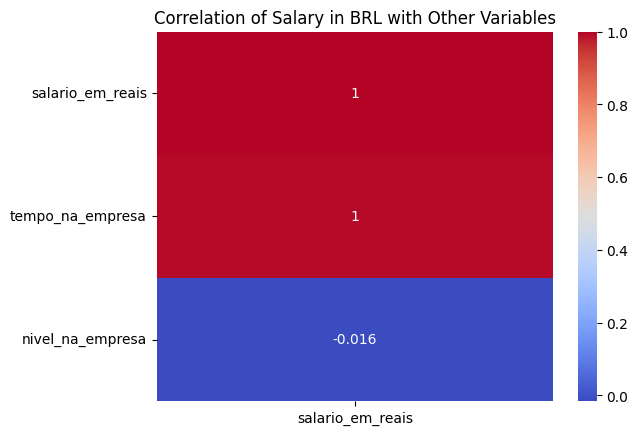

In [17]:
sns.heatmap(
    data=df_salaries_eda.corr("spearman")[["salario_em_reais"]].sort_values(
        by="salario_em_reais",
        ascending=False,
    ),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation of Salary in BRL with Other Variables")

In [18]:
tempo_na_empresa_bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]
tempo_na_empresa_labels = [
    "0-12",
    "13-24",
    "25-36",
    "37-48",
    "49-60",
    "61-72",
    "73-84",
    "85-96",
    "97-108",
    "109-120",
]

df_salaries_bucketing["escala_tempo"] = pd.cut(
    x=df_salaries_bucketing["tempo_na_empresa"],
    bins=tempo_na_empresa_bins,
    labels=tempo_na_empresa_labels,
    include_lowest=True,
)

Text(0.5, 1.0, 'Boxplot of Salary in BRL by Years at Company')

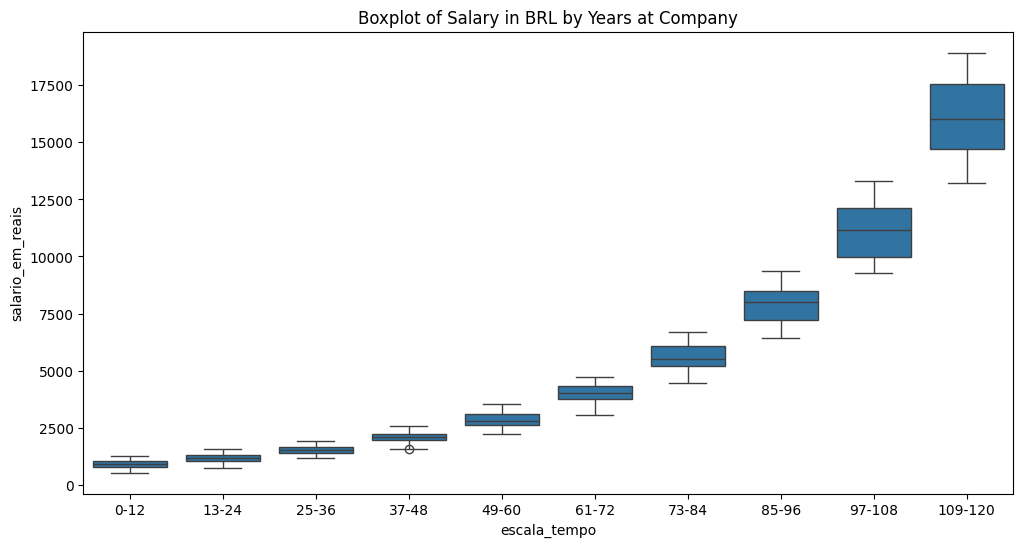

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=df_salaries_bucketing["escala_tempo"],
    y=df_salaries_bucketing["salario_em_reais"],
)
plt.title("Boxplot of Salary in BRL by Years at Company")

## Training a Linear Regression Model


In [20]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np

In [21]:
X = df_salaries.drop(columns=["salario_em_reais"], axis=1)
y = df_salaries["salario_em_reais"]

In [22]:
# Split dataset using KFold with five folders/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [23]:
# Create a pipeline for the model
numeric_features = ["tempo_na_empresa", "nivel_na_empresa"]
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ]
)

linear_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

In [24]:
# Store the root mean squared error for each train/test split
rmse_scores_train_fold = []
rmse_scores_test_fold = []

# Store the R2 score and residuals for each test fold
r2_scores_test_fold = []
residuals = []

# Store the predicted values for each test fold
y_pred_total = []

# Iterate over each train/test split
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    linear_model.fit(X_train, y_train)

    # Predict the values
    y_pred_train = linear_model.predict(X_train)
    y_pred_test = linear_model.predict(X_test)

    # Calculate the RMSE for the train/test split
    rmse_scores_train_fold.append(root_mean_squared_error(y_train, y_pred_train))
    rmse_scores_test_fold.append(root_mean_squared_error(y_test, y_pred_test))

    # Calculate the R2 score for the test split
    r2_scores_test_fold.append(r2_score(y_test, y_pred_test))

    # Store the residuals
    residuals_test = np.array(y_test - y_pred_test)
    residuals.append(residuals_test)

    # Store the predicted values
    y_pred_total.append(y_pred_test)

# Calculate the average RMSE for the train/test splits
rmse_train_avg = np.mean(rmse_scores_train_fold)
rmse_test_avg = np.mean(rmse_scores_test_fold)
rmse_percent_diff = (rmse_test_avg - rmse_train_avg) / rmse_train_avg

# Calculate the average R2 score for the test splits
r2_test_avg = np.mean(r2_scores_test_fold)

# Calculate the residuals and predicted values
residuals_total = np.concatenate(residuals)
y_pred_total = np.concatenate(y_pred_total)

### Linear Regression Model Metrics


In [25]:
print(f"Average RMSE (Train): {rmse_train_avg:.2f}")
print(f"Average RMSE (Test): {rmse_test_avg:.2f}")
print(f"RMSE Percent Difference: {rmse_percent_diff:.2%}")
print(f"Average R2 Score (Test): {r2_test_avg:.2f}")

Average RMSE (Train): 1882.83
Average RMSE (Test): 1886.45
RMSE Percent Difference: 0.19%
Average R2 Score (Test): 0.83


### Linear Regression Residuals Analysis


In [26]:
from scipy.stats import zscore

# Calculate the z-scores for the residuals
residuals_z = zscore(residuals_total)

Text(0.5, 1.0, 'Residuals vs Predicted Values')

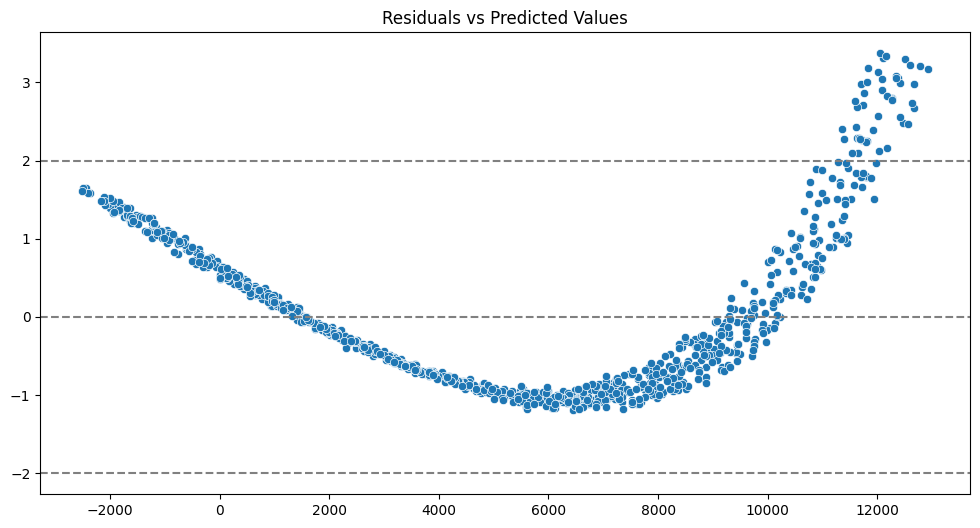

In [27]:
# Verify linearity and homoscedasticity of the residuals. To be considered linear, the residuals must
# be between -2 and 2 standard deviations of the mean. To be considered homoscedastic, the residuals
# must be evenly distributed around the mean (center line) and not form a pattern.
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_total, y=residuals_z)
plt.axhline(y=0, color="gray", linestyle="--")
plt.axhline(y=2, color="gray", linestyle="--")
plt.axhline(y=-2, color="gray", linestyle="--")
plt.title("Residuals vs Predicted Values")

Text(0.5, 1.0, 'QQ Plot of Residuals')

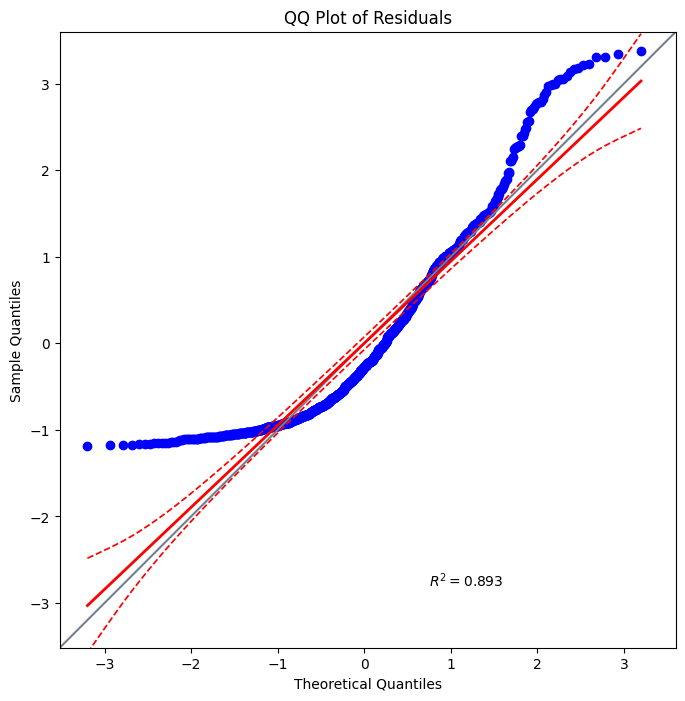

In [28]:
# Verify the normality of the residuals using a Q-Q plot
import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuals_total, dist="norm", confidence=0.95)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("QQ Plot of Residuals")

In [29]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

# Shapiro-Wilk test
_, p_value_shapiro = shapiro(residuals_total)
alpha = 0.05

print(f"Shapiro-Wilk Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_shapiro}")

if p_value_shapiro > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Shapiro-Wilk Test (H0: Residuals are Normally Distributed)
p-value: 7.013497918014801e-26
Reject the null hypothesis


In [30]:
_, p_value_ks = kstest(residuals_total, "norm")
alpha = 0.05

print(f"Kolmogorov-Smirnov Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_ks}")

if p_value_ks > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Kolmogorov-Smirnov Test (H0: Residuals are Normally Distributed)
p-value: 0.0
Reject the null hypothesis


In [31]:
_, p_value_lilliefors = lilliefors(residuals_total)
alpha = 0.05

print(f"Lilliefors Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_lilliefors}")

if p_value_lilliefors > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Lilliefors Test (H0: Residuals are Normally Distributed)
p-value: 0.0009999999999998899
Reject the null hypothesis


## Training a Polynomial Regression Model


In [32]:
from sklearn.preprocessing import PolynomialFeatures

# Example of polynomial features
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [33]:
# Get the feature names
poly_features.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [34]:
# Get the feature names after transformation
poly_features.get_feature_names_out()

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [35]:
# Split dataset using KFold with five folders/splits
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [36]:
# Define the polynomial degrees to test
polynomial_degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
polynomial_models = []

# Store the RMSE and R2 score values for each degree
rmse_train_values = []
rmse_test_values = []
rmse_percent_diff_values = []
r2_test_values = []

for degree in polynomial_degrees:
    # Create a pipeline for the model
    numeric_features = ["tempo_na_empresa", "nivel_na_empresa"]
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            (
                "poly",
                PolynomialFeatures(degree, include_bias=False),
                numeric_features,
            ),
        ]
    )

    polynomial_model = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression()),
        ]
    )
    polynomial_models.append(polynomial_model)

    # Store the root mean squared error for each train/test split
    rmse_scores_train_fold = []
    rmse_scores_test_fold = []

    # Store the R2 score and residuals for each test fold
    r2_scores_test_fold = []
    residuals = []

    # Store the predicted values for each test fold
    y_pred_total = []

    # Iterate over each train/test split
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        polynomial_model.fit(X_train, y_train)

        # Predict the values
        y_pred_train = polynomial_model.predict(X_train)
        y_pred_test = polynomial_model.predict(X_test)

        # Calculate the RMSE for the train/test split
        rmse_scores_train_fold.append(root_mean_squared_error(y_train, y_pred_train))
        rmse_scores_test_fold.append(root_mean_squared_error(y_test, y_pred_test))

        # Calculate the R2 score for the test split
        r2_scores_test_fold.append(r2_score(y_test, y_pred_test))

        # Store the residuals
        residuals_test = np.array(y_test - y_pred_test)
        residuals.append(residuals_test)

        # Store the predicted values
        y_pred_total.append(y_pred_test)

    # Calculate the average RMSE for the train/test splits
    rmse_train_avg = np.mean(rmse_scores_train_fold)
    rmse_test_avg = np.mean(rmse_scores_test_fold)
    rmse_percent_diff = (rmse_test_avg - rmse_train_avg) / rmse_train_avg

    # Calculate the average R2 score for the test splits
    r2_test_avg = np.mean(r2_scores_test_fold)

    # Store the RMSE and R2 score values
    rmse_train_values.append(rmse_train_avg)
    rmse_test_values.append(rmse_test_avg)
    rmse_percent_diff_values.append(rmse_percent_diff)
    r2_test_values.append(r2_test_avg)

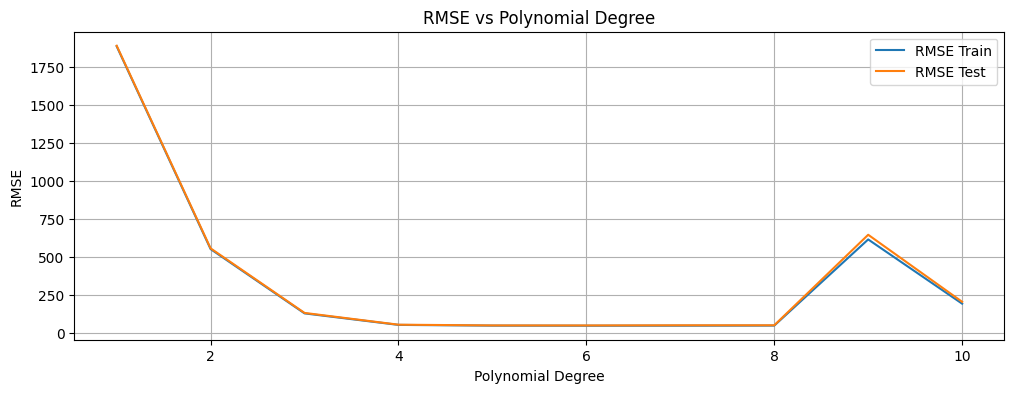

In [37]:
# Plot the RMSE values for each polynomial degree
plt.figure(figsize=(12, 4))
plt.plot(polynomial_degrees, rmse_train_values, label="RMSE Train")
plt.plot(polynomial_degrees, rmse_test_values, label="RMSE Test")
plt.title("RMSE vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

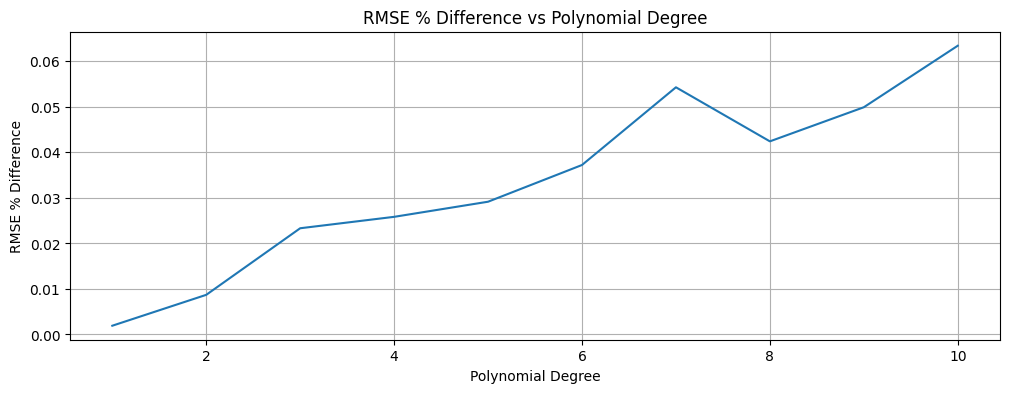

In [41]:
# Plot the RMSE difference values for each polynomial degree
plt.figure(figsize=(12, 4))
plt.plot(polynomial_degrees, rmse_percent_diff_values, label="RMSE % Difference")
plt.title("RMSE % Difference vs Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE % Difference")
plt.grid(True)
plt.show()

In [62]:
# Calculate the best polynomial degree with lowest percent difference
best_degree = polynomial_degrees[np.argmin(rmse_test_values)]
best_degree_rmse = rmse_test_values[best_degree - 1]
best_degree_rmse_percent_diff = rmse_percent_diff_values[best_degree - 1]
best_degree_r2 = r2_test_values[best_degree - 1]

print(f"Best Polynomial Degree: {best_degree}")
print(f"Best Polynomial Degree RMSE: {best_degree_rmse:.2f}")
print(
    f"Best Polynomial Degree RMSE Percent Difference: {best_degree_rmse_percent_diff:.2%}"
)
print(f"Best Polynomial Degree R2 Score: {best_degree_r2}")

Best Polynomial Degree: 6
Best Polynomial Degree RMSE: 49.71
Best Polynomial Degree RMSE Percent Difference: 3.72%
Best Polynomial Degree R2 Score: 0.9998778671278057


In [64]:
# Pick the best polynomial model
polynomial_model = polynomial_models[best_degree - 1]

### Polynomial Regression Model Metrics


In [65]:
# Store the root mean squared error for each train/test split
rmse_scores_train_fold = []
rmse_scores_test_fold = []

# Store the R2 score and residuals for each test fold
r2_scores_test_fold = []
residuals = []

# Store the predicted values for each test fold
y_pred_total = []

# Iterate over each train/test split
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    polynomial_model.fit(X_train, y_train)

    # Predict the values
    y_pred_train = polynomial_model.predict(X_train)
    y_pred_test = polynomial_model.predict(X_test)

    # Calculate the RMSE for the train/test split
    rmse_scores_train_fold.append(root_mean_squared_error(y_train, y_pred_train))
    rmse_scores_test_fold.append(root_mean_squared_error(y_test, y_pred_test))

    # Calculate the R2 score for the test split
    r2_scores_test_fold.append(r2_score(y_test, y_pred_test))

    # Store the residuals
    residuals_test = np.array(y_test - y_pred_test)
    residuals.append(residuals_test)

    # Store the predicted values
    y_pred_total.append(y_pred_test)

# Calculate the average RMSE for the train/test splits
rmse_train_avg = np.mean(rmse_scores_train_fold)
rmse_test_avg = np.mean(rmse_scores_test_fold)
rmse_percent_diff = (rmse_test_avg - rmse_train_avg) / rmse_train_avg

# Calculate the average R2 score for the test splits
r2_test_avg = np.mean(r2_scores_test_fold)

# Calculate the residuals and predicted values
residuals_total = np.concatenate(residuals)
y_pred_total = np.concatenate(y_pred_total)

In [73]:
print(f"Average RMSE (Train): {rmse_train_avg:.4f}")
print(f"Average RMSE (Test): {rmse_test_avg:.4f}")
print(f"RMSE Percent Difference: {rmse_percent_diff:.4%}")
print(f"Average R4 Score (Test): {r2_test_avg:.4f}")

Average RMSE (Train): 47.9300
Average RMSE (Test): 49.7144
RMSE Percent Difference: 3.7229%
Average R4 Score (Test): 0.9999


### Polynomial Regression Residuals Analysis


In [74]:
from scipy.stats import zscore

# Calculate the z-scores for the residuals
residuals_z = zscore(residuals_total)

Text(0.5, 1.0, 'Residuals vs Predicted Values')

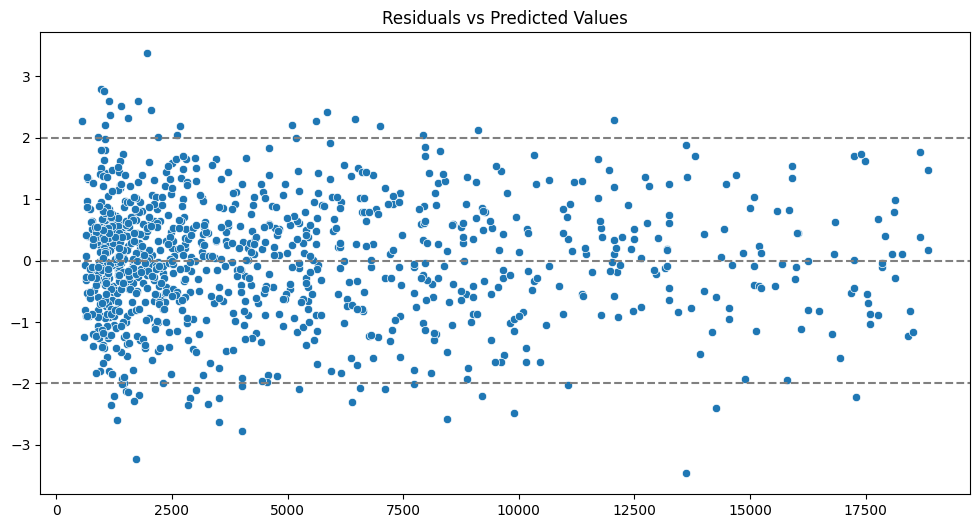

In [75]:
# Verify linearity and homoscedasticity of the residuals. To be considered linear, the residuals must
# be between -2 and 2 standard deviations of the mean. To be considered homoscedastic, the residuals
# must be evenly distributed around the mean (center line) and not form a pattern.
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred_total, y=residuals_z)
plt.axhline(y=0, color="gray", linestyle="--")
plt.axhline(y=2, color="gray", linestyle="--")
plt.axhline(y=-2, color="gray", linestyle="--")
plt.title("Residuals vs Predicted Values")

Text(0.5, 1.0, 'QQ Plot of Residuals')

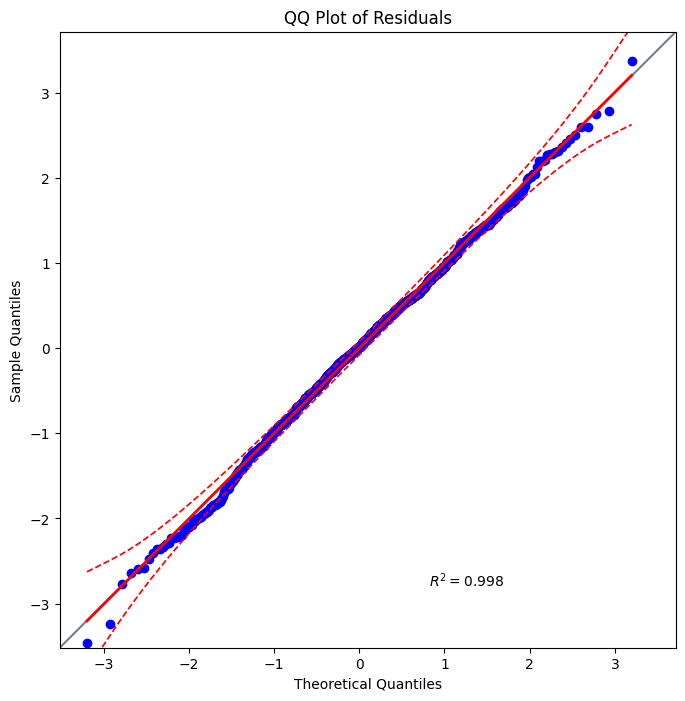

In [76]:
# Verify the normality of the residuals using a Q-Q plot
import pingouin as pg

plt.figure(figsize=(14, 8))
pg.qqplot(residuals_total, dist="norm", confidence=0.95)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("QQ Plot of Residuals")

In [77]:
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors

# Shapiro-Wilk test
_, p_value_shapiro = shapiro(residuals_total)
alpha = 0.05

print(f"Shapiro-Wilk Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_shapiro}")

if p_value_shapiro > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Shapiro-Wilk Test (H0: Residuals are Normally Distributed)
p-value: 0.349841344664033
Fail to reject the null hypothesis


In [78]:
_, p_value_ks = kstest(residuals_total, "norm")
alpha = 0.05

print(f"Kolmogorov-Smirnov Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_ks}")

if p_value_ks > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Kolmogorov-Smirnov Test (H0: Residuals are Normally Distributed)
p-value: 4.343594809740073e-218
Reject the null hypothesis


In [79]:
_, p_value_lilliefors = lilliefors(residuals_total)
alpha = 0.05

print(f"Lilliefors Test (H0: Residuals are Normally Distributed)")
print(f"p-value: {p_value_lilliefors}")

if p_value_lilliefors > alpha:
    print("Fail to reject the null hypothesis")
else:
    print("Reject the null hypothesis")

Lilliefors Test (H0: Residuals are Normally Distributed)
p-value: 0.21615271964822613
Fail to reject the null hypothesis


## Individual prediction


In [86]:
input_features = {
    "tempo_na_empresa": 72,
    "nivel_na_empresa": 8,
}

df_prediction = pd.DataFrame([input_features])
y_pred = polynomial_model.predict(df_prediction)

print(f"Predicted Salary in BRL: {y_pred[0]:.2f}")

Predicted Salary in BRL: 4735.91


## Saving the model


In [87]:
import joblib
import os

os.makedirs("models", exist_ok=True)
joblib.dump(polynomial_model, f"models/salary_model.pkl")

['models/salaries_model.pkl']